# Method 5 - Best Ideas Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

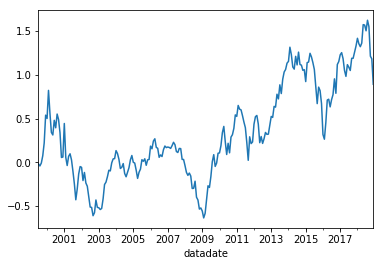

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.538402
2000-12-31   -0.311094
2001-12-31   -0.102893
2002-12-31   -0.490301
2003-12-31    1.149540
2004-12-31    0.034104
2005-12-31   -0.041638
2006-12-31    0.131135
2007-12-31   -0.116242
2008-12-31   -0.536914
2009-12-31    1.307939
2010-12-31    0.397432
2011-12-31   -0.200780
2012-12-31    0.158043
2013-12-31    0.495098
2014-12-31   -0.034822
2015-12-31   -0.188442
2016-12-31    0.287277
2017-12-31    0.082686
2018-12-31   -0.187624
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     280.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.65e-87
Time:                        05:34:38   Log-Likelihood:                 403.23
No. Observations:                 234   AIC:                            -796.5
Df Residuals:                     229   BIC:                            -779.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      2.044      0.042       0.000       0.012
mktrf          1.2859      0.081     15.792      0.000       1.125       1.446
me             0.5277      0.095      5.571      0.000       0.341       0.714
ia            -0.0670      0.144     -0.466      0.642      -0.351       0.217
roe           -1.3872      0.123    -11.258      0.000      -1.630      -1.144
==============================================================================
Omnibus:                      125.976   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.029
Skew:                           1.909   Prob(JB):                    5.68e-252
Kurtosis:                      13.202   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     84.14
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.65e-44
Time:                        05:34:38   Log-Likelihood:                 403.23
No. Observations:                 234   AIC:                            -796.5
Df Residuals:                     229   BIC:                            -779.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.003      1.768      0.077      -0.001       0.013
mktrf          1.2859      0.149      8.608      0.000       0.993       1.579
me             0.5277      0.117      4.529      0.000       0.299       0.756
ia            -0.0670      0.184     -0.364      0.716      -0.428       0.294
roe           -1.3872      0.180     -7.701      0.000      -1.740      -1.034
==============================================================================
Omnibus:                      125.976   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.029
Skew:                           1.909   Prob(JB):                    5.68e-252
Kurtosis:                      13.202   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     100.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.53e-49
Time:                        05:34:38   Log-Likelihood:                 403.23
No. Observations:                 234   AIC:                            -796.5
Df Residuals:                     229   BIC:                            -779.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.004      1.583      0.113      -0.001       0.014
mktrf          1.2859      0.151      8.529      0.000       0.990       1.581
me             0.5277      0.138      3.836      0.000       0.258       0.797
ia            -0.0670      0.174     -0.386      0.700      -0.408       0.274
roe           -1.3872      0.199     -6.966      0.000      -1.778      -0.997
==============================================================================
Omnibus:                      125.976   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1157.029
Skew:                           1.909   Prob(JB):                    5.68e-252
Kurtosis:                      13.202   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     180.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.87e-77
Time:                        05:34:38   Log-Likelihood:                 382.68
No. Observations:                 234   AIC:                            -753.4
Df Residuals:                     228   BIC:                            -732.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.003      1.387      0.167      -0.002       0.011
mktrf          1.4345      0.089     16.070      0.000       1.259       1.610
smb            0.6205      0.118      5.268      0.000       0.388       0.853
hml            0.2856      0.139      2.056      0.041       0.012       0.559
rmw           -1.1567      0.157     -7.366      0.000      -1.466      -0.847
cma           -0.1664      0.200     -0.834      0.405      -0.560       0.227
==============================================================================
Omnibus:                      126.358   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              770.840
Skew:                           2.097   Prob(JB):                    4.11e-168
Kurtosis:                      10.840   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     75.63
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.80e-46
Time:                        05:34:38   Log-Likelihood:                 382.68
No. Observations:                 234   AIC:                            -753.4
Df Residuals:                     228   BIC:                            -732.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.004      1.184      0.236      -0.003       0.012
mktrf          1.4345      0.100     14.275      0.000       1.238       1.632
smb            0.6205      0.133      4.674      0.000       0.360       0.881
hml            0.2856      0.222      1.289      0.198      -0.149       0.720
rmw           -1.1567      0.210     -5.519      0.000      -1.568      -0.746
cma           -0.1664      0.330     -0.504      0.614      -0.814       0.481
==============================================================================
Omnibus:                      126.358   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              770.840
Skew:                           2.097   Prob(JB):                    4.11e-168
Kurtosis:                      10.840   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     89.49
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.60e-52
Time:                        05:34:38   Log-Likelihood:                 382.68
No. Observations:                 234   AIC:                            -753.4
Df Residuals:                     228   BIC:                            -732.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.004      1.044      0.297      -0.004       0.013
mktrf          1.4345      0.089     16.163      0.000       1.261       1.609
smb            0.6205      0.129      4.815      0.000       0.368       0.873
hml            0.2856      0.182      1.568      0.117      -0.071       0.643
rmw           -1.1567      0.228     -5.069      0.000      -1.604      -0.710
cma           -0.1664      0.331     -0.502      0.615      -0.816       0.483
==============================================================================
Omnibus:                      126.358   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              770.840
Skew:                           2.097   Prob(JB):                    4.11e-168
Kurtosis:                      10.840   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     253.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.01e-83
Time:                        05:34:38   Log-Likelihood:                 393.38
No. Observations:                 234   AIC:                            -776.8
Df Residuals:                     229   BIC:                            -759.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.531      0.596      -0.004       0.008
mktrf          1.4727      0.078     18.834      0.000       1.319       1.627
smb            1.1788      0.098     12.077      0.000       0.986       1.371
hml           -0.1150      0.097     -1.186      0.237      -0.306       0.076
umd           -0.5707      0.064     -8.971      0.000      -0.696      -0.445
==============================================================================
Omnibus:                       94.958   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.748
Skew:                           1.464   Prob(JB):                    1.29e-126
Kurtosis:                      10.134   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     164.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.64e-66
Time:                        05:34:38   Log-Likelihood:                 393.38
No. Observations:                 234   AIC:                            -776.8
Df Residuals:                     229   BIC:                            -759.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.552      0.581      -0.004       0.007
mktrf          1.4727      0.123     12.001      0.000       1.232       1.713
smb            1.1788      0.091     13.011      0.000       1.001       1.356
hml           -0.1150      0.137     -0.843      0.399      -0.383       0.153
umd           -0.5707      0.092     -6.205      0.000      -0.751      -0.390
==============================================================================
Omnibus:                       94.958   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.748
Skew:                           1.464   Prob(JB):                    1.29e-126
Kurtosis:                      10.134   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     142.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.49e-61
Time:                        05:34:38   Log-Likelihood:                 393.38
No. Observations:                 234   AIC:                            -776.8
Df Residuals:                     229   BIC:                            -759.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.534      0.594      -0.004       0.008
mktrf          1.4727      0.113     12.994      0.000       1.251       1.695
smb            1.1788      0.090     13.040      0.000       1.002       1.356
hml           -0.1150      0.126     -0.916      0.360      -0.361       0.131
umd           -0.5707      0.087     -6.578      0.000      -0.741      -0.401
==============================================================================
Omnibus:                       94.958   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              579.748
Skew:                           1.464   Prob(JB):                    1.29e-126
Kurtosis:                      10.134   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     134.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.08e-42
Time:                        05:34:38   Log-Likelihood:                 185.86
No. Observations:                 120   AIC:                            -361.7
Df Residuals:                     115   BIC:                            -347.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0125      0.005      2.492      0.014       0.003       0.022
mktrf          1.1408      0.135      8.427      0.000       0.873       1.409
me             0.3712      0.134      2.776      0.006       0.106       0.636
ia            -0.2140      0.209     -1.022      0.309      -0.629       0.201
roe           -1.5019      0.185     -8.104      0.000      -1.869      -1.135
==============================================================================
Omnibus:                       48.757   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.358
Skew:                           1.382   Prob(JB):                     5.63e-41
Kurtosis:                       8.425   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     74.20
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.95e-31
Time:                        05:34:38   Log-Likelihood:                 185.86
No. Observations:                 120   AIC:                            -361.7
Df Residuals:                     115   BIC:                            -347.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0125      0.005      2.323      0.020       0.002       0.023
mktrf          1.1408      0.202      5.640      0.000       0.744       1.537
me             0.3712      0.141      2.639      0.008       0.096       0.647
ia            -0.2140      0.249     -0.860      0.390      -0.702       0.274
roe           -1.5019      0.224     -6.705      0.000      -1.941      -1.063
==============================================================================
Omnibus:                       48.757   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.358
Skew:                           1.382   Prob(JB):                     5.63e-41
Kurtosis:                       8.425   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     89.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.06e-34
Time:                        05:34:38   Log-Likelihood:                 185.86
No. Observations:                 120   AIC:                            -361.7
Df Residuals:                     115   BIC:                            -347.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0125      0.006      2.139      0.032       0.001       0.024
mktrf          1.1408      0.200      5.711      0.000       0.749       1.532
me             0.3712      0.170      2.186      0.029       0.038       0.704
ia            -0.2140      0.239     -0.895      0.371      -0.682       0.254
roe           -1.5019      0.257     -5.847      0.000      -2.005      -0.998
==============================================================================
Omnibus:                       48.757   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.358
Skew:                           1.382   Prob(JB):                     5.63e-41
Kurtosis:                       8.425   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     82.14
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.77e-36
Time:                        05:34:38   Log-Likelihood:                 173.26
No. Observations:                 120   AIC:                            -334.5
Df Residuals:                     114   BIC:                            -317.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0119      0.006      2.076      0.040       0.001       0.023
mktrf          1.4654      0.159      9.202      0.000       1.150       1.781
smb            0.5261      0.180      2.917      0.004       0.169       0.883
hml            0.0817      0.221      0.369      0.712      -0.356       0.519
rmw           -1.0444      0.261     -4.007      0.000      -1.561      -0.528
cma           -0.1405      0.286     -0.492      0.624      -0.706       0.425
==============================================================================
Omnibus:                       62.286   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.821
Skew:                           1.954   Prob(JB):                     9.08e-45
Kurtosis:                       8.030   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     32.83
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.29e-20
Time:                        05:34:38   Log-Likelihood:                 173.26
No. Observations:                 120   AIC:                            -334.5
Df Residuals:                     114   BIC:                            -317.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0119      0.006      1.957      0.050   -1.78e-05       0.024
mktrf          1.4654      0.176      8.319      0.000       1.120       1.811
smb            0.5261      0.189      2.777      0.005       0.155       0.897
hml            0.0817      0.225      0.362      0.717      -0.360       0.523
rmw           -1.0444      0.282     -3.704      0.000      -1.597      -0.492
cma           -0.1405      0.391     -0.360      0.719      -0.906       0.625
==============================================================================
Omnibus:                       62.286   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.821
Skew:                           1.954   Prob(JB):                     9.08e-45
Kurtosis:                       8.030   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     38.41
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.05e-23
Time:                        05:34:38   Log-Likelihood:                 173.26
No. Observations:                 120   AIC:                            -334.5
Df Residuals:                     114   BIC:                            -317.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0119      0.007      1.749      0.080      -0.001       0.025
mktrf          1.4654      0.150      9.738      0.000       1.170       1.760
smb            0.5261      0.185      2.843      0.004       0.163       0.889
hml            0.0817      0.203      0.402      0.687      -0.316       0.479
rmw           -1.0444      0.319     -3.272      0.001      -1.670      -0.419
cma           -0.1405      0.393     -0.357      0.721      -0.912       0.631
==============================================================================
Omnibus:                       62.286   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.821
Skew:                           1.954   Prob(JB):                     9.08e-45
Kurtosis:                       8.030   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     131.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.51e-42
Time:                        05:34:38   Log-Likelihood:                 184.84
No. Observations:                 120   AIC:                            -359.7
Df Residuals:                     115   BIC:                            -345.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.005      1.511      0.133      -0.002       0.017
mktrf          1.4633      0.120     12.165      0.000       1.225       1.702
smb            1.1149      0.137      8.141      0.000       0.844       1.386
hml           -0.3219      0.137     -2.347      0.021      -0.594      -0.050
umd           -0.5709      0.085     -6.751      0.000      -0.738      -0.403
==============================================================================
Omnibus:                       48.210   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.189
Skew:                           1.368   Prob(JB):                     4.52e-40
Kurtosis:                       8.362   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     137.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.88e-43
Time:                        05:34:38   Log-Likelihood:                 184.84
No. Observations:                 120   AIC:                            -359.7
Df Residuals:                     115   BIC:                            -345.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.004      1.682      0.093      -0.001       0.016
mktrf          1.4633      0.182      8.055      0.000       1.107       1.819
smb            1.1149      0.122      9.159      0.000       0.876       1.353
hml           -0.3219      0.172     -1.874      0.061      -0.659       0.015
umd           -0.5709      0.097     -5.904      0.000      -0.760      -0.381
==============================================================================
Omnibus:                       48.210   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.189
Skew:                           1.368   Prob(JB):                     4.52e-40
Kurtosis:                       8.362   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     130.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.77e-42
Time:                        05:34:38   Log-Likelihood:                 184.84
No. Observations:                 120   AIC:                            -359.7
Df Residuals:                     115   BIC:                            -345.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0075      0.005      1.659      0.097      -0.001       0.016
mktrf          1.4633      0.169      8.648      0.000       1.132       1.795
smb            1.1149      0.120      9.320      0.000       0.880       1.349
hml           -0.3219      0.159     -2.027      0.043      -0.633      -0.011
umd           -0.5709      0.089     -6.428      0.000      -0.745      -0.397
==============================================================================
Omnibus:                       48.210   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.189
Skew:                           1.368   Prob(JB):                     4.52e-40
Kurtosis:                       8.362   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     192.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.18e-48
Time:                        05:34:38   Log-Likelihood:                 241.69
No. Observations:                 114   AIC:                            -473.4
Df Residuals:                     109   BIC:                            -459.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.105      0.917      -0.006       0.006
mktrf          1.4129      0.087     16.182      0.000       1.240       1.586
me             0.7915      0.135      5.871      0.000       0.524       1.059
ia             0.0998      0.187      0.533      0.595      -0.271       0.470
roe           -1.3377      0.164     -8.141      0.000      -1.663      -1.012
==============================================================================
Omnibus:                       15.053   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.374
Skew:                           0.618   Prob(JB):                     8.40e-06
Kurtosis:                       4.843   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     135.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.74e-41
Time:                        05:34:38   Log-Likelihood:                 241.69
No. Observations:                 114   AIC:                            -473.4
Df Residuals:                     109   BIC:                            -459.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.131      0.896      -0.005       0.004
mktrf          1.4129      0.116     12.213      0.000       1.186       1.640
me             0.7915      0.174      4.539      0.000       0.450       1.133
ia             0.0998      0.188      0.531      0.595      -0.268       0.468
roe           -1.3377      0.239     -5.603      0.000      -1.806      -0.870
==============================================================================
Omnibus:                       15.053   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.374
Skew:                           0.618   Prob(JB):                     8.40e-06
Kurtosis:                       4.843   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     143.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.75e-42
Time:                        05:34:38   Log-Likelihood:                 241.69
No. Observations:                 114   AIC:                            -473.4
Df Residuals:                     109   BIC:                            -459.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.140      0.889      -0.005       0.004
mktrf          1.4129      0.114     12.390      0.000       1.189       1.636
me             0.7915      0.207      3.828      0.000       0.386       1.197
ia             0.0998      0.199      0.502      0.616      -0.290       0.489
roe           -1.3377      0.249     -5.379      0.000      -1.825      -0.850
==============================================================================
Omnibus:                       15.053   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.374
Skew:                           0.618   Prob(JB):                     8.40e-06
Kurtosis:                       4.843   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     137.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.39e-45
Time:                        05:34:38   Log-Likelihood:                 236.76
No. Observations:                 114   AIC:                            -461.5
Df Residuals:                     108   BIC:                            -445.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.755      0.452      -0.009       0.004
mktrf          1.4559      0.087     16.666      0.000       1.283       1.629
smb            0.7171      0.142      5.056      0.000       0.436       0.998
hml            0.5513      0.181      3.048      0.003       0.193       0.910
rmw           -1.2966      0.221     -5.854      0.000      -1.736      -0.858
cma           -0.2385      0.281     -0.848      0.398      -0.796       0.319
==============================================================================
Omnibus:                        5.982   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.461
Skew:                           0.336   Prob(JB):                       0.0395
Kurtosis:                       3.953   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     106.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.46e-40
Time:                        05:34:38   Log-Likelihood:                 236.76
No. Observations:                 114   AIC:                            -461.5
Df Residuals:                     108   BIC:                            -445.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.691      0.489      -0.009       0.004
mktrf          1.4559      0.094     15.544      0.000       1.272       1.639
smb            0.7171      0.144      4.980      0.000       0.435       0.999
hml            0.5513      0.172      3.212      0.001       0.215       0.888
rmw           -1.2966      0.248     -5.218      0.000      -1.784      -0.810
cma           -0.2385      0.250     -0.955      0.339      -0.728       0.251
==============================================================================
Omnibus:                        5.982   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.461
Skew:                           0.336   Prob(JB):                       0.0395
Kurtosis:                       3.953   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     103.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.40e-39
Time:                        05:34:38   Log-Likelihood:                 236.76
No. Observations:                 114   AIC:                            -461.5
Df Residuals:                     108   BIC:                            -445.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.003     -0.701      0.483      -0.009       0.004
mktrf          1.4559      0.097     15.001      0.000       1.266       1.646
smb            0.7171      0.160      4.486      0.000       0.404       1.030
hml            0.5513      0.149      3.710      0.000       0.260       0.843
rmw           -1.2966      0.221     -5.864      0.000      -1.730      -0.863
cma           -0.2385      0.266     -0.897      0.370      -0.759       0.282
==============================================================================
Omnibus:                        5.982   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.461
Skew:                           0.336   Prob(JB):                       0.0395
Kurtosis:                       3.953   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     143.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.04e-42
Time:                        05:34:38   Log-Likelihood:                 227.27
No. Observations:                 114   AIC:                            -444.5
Df Residuals:                     109   BIC:                            -430.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.003     -1.064      0.289      -0.010       0.003
mktrf          1.4995      0.094     15.969      0.000       1.313       1.686
smb            1.0253      0.146      7.002      0.000       0.735       1.316
hml            0.4397      0.151      2.916      0.004       0.141       0.739
umd           -0.4574      0.114     -4.021      0.000      -0.683      -0.232
==============================================================================
Omnibus:                       10.259   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               15.355
Skew:                           0.418   Prob(JB):                     0.000463
Kurtosis:                       4.591   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     167.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.40e-45
Time:                        05:34:38   Log-Likelihood:                 227.27
No. Observations:                 114   AIC:                            -444.5
Df Residuals:                     109   BIC:                            -430.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.003     -1.265      0.206      -0.009       0.002
mktrf          1.4995      0.099     15.175      0.000       1.306       1.693
smb            1.0253      0.148      6.933      0.000       0.735       1.315
hml            0.4397      0.164      2.683      0.007       0.118       0.761
umd           -0.4574      0.118     -3.881      0.000      -0.688      -0.226
==============================================================================
Omnibus:                       10.259   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               15.355
Skew:                           0.418   Prob(JB):                     0.000463
Kurtosis:                       4.591   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     212.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-50
Time:                        05:34:38   Log-Likelihood:                 227.27
No. Observations:                 114   AIC:                            -444.5
Df Residuals:                     109   BIC:                            -430.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0036      0.003     -1.351      0.177      -0.009       0.002
mktrf          1.4995      0.098     15.321      0.000       1.308       1.691
smb            1.0253      0.137      7.510      0.000       0.758       1.293
hml            0.4397      0.156      2.816      0.005       0.134       0.746
umd           -0.4574      0.117     -3.897      0.000      -0.687      -0.227
==============================================================================
Omnibus:                       10.259   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               15.355
Skew:                           0.418   Prob(JB):                     0.000463
Kurtosis:                       4.591   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""